1. Gerekli kütüphaneler

In [49]:
# 🌟 Veri işleme ve analiz için temel kütüphaneler
import pandas as pd  # Veri okuma, işleme ve DataFrame oluşturma işlemleri için
import numpy as np   # Sayısal işlemler, diziler ve matematiksel hesaplamalar için

# 🔧 Veri ölçeklendirme ve değerlendirme metrikleri
from sklearn.preprocessing import StandardScaler  # Verileri ölçeklendirmek (standartlaştırmak) için
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve  # Model performansını değerlendirmek için

# 🚀 Yapay Sinir Ağı (ANN) modelleri için TensorFlow ve Keras bileşenleri
from tensorflow.keras.models import Sequential  # Keras ile sıralı model oluşturmak için
from tensorflow.keras.layers import Dense, Dropout, Input  # Yapay sinir ağı katmanları (yoğun, dropout ve giriş)
from tensorflow.keras.utils import to_categorical  # Kategorik hedef değişkeni one-hot encoding formatına dönüştürmek için
from tensorflow.keras.callbacks import EarlyStopping  # Model eğitimini erken durdurmak için (overfitting'i önlemek amacıyla)

# ⚖️ Sınıf dengesizlik sorununu çözmek için SMOTE yöntemi
from imblearn.over_sampling import SMOTE  # Azınlık sınıfı örneklerini artırmak (dengeleme) için
from collections import Counter  # Sınıf dağılımını saymak ve analiz etmek için

# 📊 Görselleştirme ve analiz grafikleri oluşturmak için
import matplotlib.pyplot as plt  # Grafikler ve görselleştirmeler oluşturmak için
import seaborn as sns  # Estetik görseller ve gelişmiş grafik stilleri için

2. Veriyi okuma

In [50]:
# Verileri oku
train_df = pd.read_csv("../datasets/normal/train_mental.csv")
test_df = pd.read_csv("../datasets/normal/test_mental.csv")

# Özellik ve hedef ayır
X_train = train_df.drop("support_needed", axis=1)
y_train = train_df["support_needed"]

X_test = test_df.drop("support_needed", axis=1)
y_test = test_df["support_needed"]

print("✅ Eğitim verisi:", X_train.shape)
print("✅ Test verisi:", X_test.shape)
print("🎯 Sınıf dağılımı (y_train):\n", pd.Series(y_train).value_counts())

✅ Eğitim verisi: (1007, 23)
✅ Test verisi: (252, 23)
🎯 Sınıf dağılımı (y_train):
 support_needed
0    528
1    479
Name: count, dtype: int64


3. SMOTE ile veri dengeleme

In [51]:
print("🎯 Orijinal sınıf dağılımı:", Counter(y_train))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("⚖️ Dengelenmiş eğitim sınıf dağılımı:", Counter(y_train_balanced))

🎯 Orijinal sınıf dağılımı: Counter({0: 528, 1: 479})
⚖️ Dengelenmiş eğitim sınıf dağılımı: Counter({0: 528, 1: 528})


In [52]:
# 🌟 Eğitim ve test hedeflerini one-hot encode yapma
y_train_cat = to_categorical(y_train_balanced)
y_test_cat = to_categorical(y_test)

4. ANN modeli

In [53]:
model = Sequential([
    Input(shape=(X_train_balanced.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')  # 2 sınıf için sigmoid
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,474 (52.63 KB)

 Trainable params: 13,474 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

5. Model eğitimi

In [54]:
# 🌟 Eğitim sırasında erken durma kriteri
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 🚀 Model eğitimi
history = model.fit(
    X_train_balanced,            # Girdi verisi
    y_train_cat,                 # Hedef verisi
    epochs=30,                   # Maksimum dönem sayısı
    batch_size=32,               # Mini-batch boyutu
    validation_split=0.2,        # Eğitim/Doğrulama oranı
    callbacks=[early_stop],      # Erken durma kriteri
    verbose=1                    # Eğitim ilerlemesini göster
)

print("✅ Model başarıyla eğitildi.")

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5460 - loss: 0.9667 - val_accuracy: 0.7925 - val_loss: 0.4199
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7279 - loss: 0.5540 - val_accuracy: 0.8113 - val_loss: 0.4067
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7474 - loss: 0.5908 - val_accuracy: 0.8066 - val_loss: 0.4037
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7706 - loss: 0.5111 - val_accuracy: 0.8255 - val_loss: 0.3955
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7785 - loss: 0.5227 - val_accuracy: 0.8302 - val_loss: 0.3829
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7555 - loss: 0.5462 - val_accuracy: 0.8302 - val_loss: 0.3942
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7426 - loss: 0.5662 - val_accuracy: 0.8255 - val_loss: 0.3843
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7918 - loss: 0.5177 - val_accuracy: 0.8113 - v

6. Tahmin, rapor ve görselleştirme

In [55]:
# Tahmin (olasılıklar)
y_proba = model.predict(X_test)

# En yüksek olasılığa göre sınıf tahmini
y_pred = y_proba.argmax(axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


📋 Sınıflandırma Raporu (ANN):

              precision    recall  f1-score   support

           0      0.840     0.833     0.837       132
           1      0.818     0.825     0.822       120

    accuracy                          0.829       252
   macro avg      0.829     0.829     0.829       252
weighted avg      0.829     0.829     0.829       252



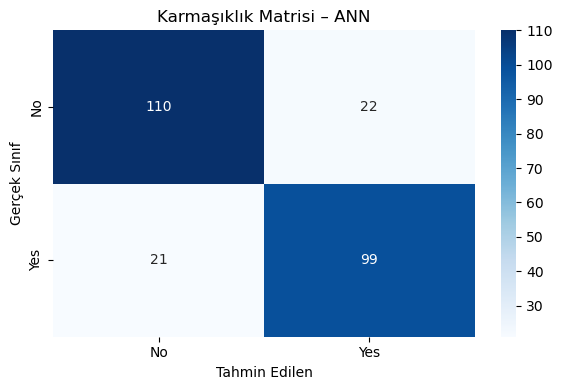

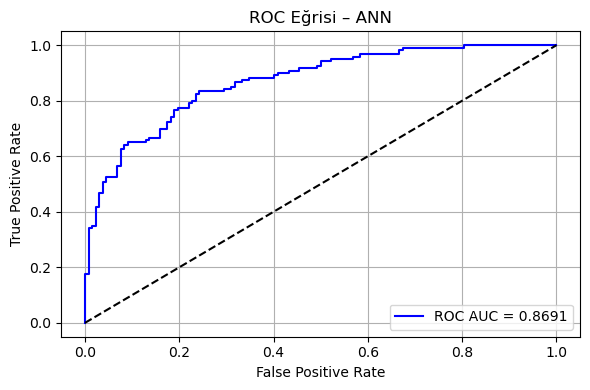

In [56]:
# 📋 Sınıflandırma raporu
print("📋 Sınıflandırma Raporu (ANN):\n")
report = classification_report(y_test, y_pred, digits=3)  # 3 basamak hassasiyeti
print(report)

# 🔍 Karmaşıklık Matrisi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Karmaşıklık Matrisi – ANN")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()

# 🌈 ROC Eğrisi
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_proba[:, 1])

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="blue")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi – ANN")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

7. Model kaydı

In [ ]:
import joblib

model.save("../saved_model/normal/mental_ann_model.keras")
joblib.dump(model, "../saved_model/normal/mental_ann_model.pkl")

print("💾 Model başarıyla kaydedildi:")
print("- mental_ann_model.keras")
print("- mental_ann_model.pkl")

💾 Model ve scaler başarıyla kaydedildi:
- mental_ann_model.keras
- mental_ann_model.pkl
